In [1]:
import pandas as pd

train_df = pd.read_csv('Train_Dataset.csv')

train_df.head()

,Unnamed: 0,tweet,sarcastic,rephrase,sarcasm,irony,satire,understatement,overstatement,rhetorical_question
0,0,The only thing I got from college is a caffein...,1,"College is really difficult, expensive, tiring...",0.0,1.0,0.0,0.0,0.0,0.0
1,1,I love it when professors draw a big question ...,1,I do not like when professors don’t write out ...,1.0,0.0,0.0,0.0,0.0,0.0
2,2,Remember the hundred emails from companies whe...,1,"I, at the bare minimum, wish companies actuall...",0.0,1.0,0.0,0.0,0.0,0.0
3,3,Today my pop-pop told me I was not “forced” to...,1,"Today my pop-pop told me I was not ""forced"" to...",1.0,0.0,0.0,0.0,0.0,0.0
4,4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1,I would say Ted Cruz is an asshole and doesn’t...,1.0,0.0,0.0,0.0,0.0,0.0


In [2]:
import numpy as np
words = dict()

def add_to_dict(d, filename):
    with open(filename, 'r') as f:
        for line in f.readlines():
            line = line.split(' ')

            try:
                d[line[0]] = np.array(line[1:], dtype=float) # separates word [line[0]] from its embeddings [line[1:]]
            except:
                continue
add_to_dict(words, 'glove.6B.50d.txt')

In [3]:
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 6.9 MB/s eta 0:00:00


In [4]:
import nltk
import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
import emoji
nltk.download('wordnet') # for nlp tasks
#Preporcess, tokenize and create embeddings
# Load the NLTK tokenizer
tokenizer =  TweetTokenizer()  #nltk.RegexpTokenizer(r"\w+")
lemmatizer = WordNetLemmatizer()

# Define URL, hashtag, and mention regex patterns
url_regex = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
hashtag_regex = re.compile(r'#\S+')
mention_regex = re.compile(r'@\w+')

def preprocess_type_II(tweet_text):
    if pd.isna(tweet_text) or tweet_text == '':
        return tweet_text

    # Convert urls to HTTPURL, user handles to @USER token, delete hashtags
    tweet_text = url_regex.sub('HTTPURL', tweet_text)
    tweet_text = mention_regex.sub('@USER', tweet_text)
    tweet_text = hashtag_regex.sub('', tweet_text)

    return tweet_text

def preprocess_type_III(tweet_text):
    if pd.isna(tweet_text) or tweet_text == '':
        return tweet_text

    # Use function to convert urls to HTTPURL, user handles to @USER token, delete hashtags
    tweet_text = preprocess_type_II(tweet_text)

    # Replace contractions with full forms
    contraction_mapping = {"isn't": "is not", "’cause": "because", "You'd": "you would", "I’m": "I am",
                           "Couldn't": "Could not", }  # Customize as needed
    for contraction, full_form in contraction_mapping.items():
        tweet_text = tweet_text.replace(contraction, full_form)

    # Convert emotion icons to their string text
    tweet_text = emoji.demojize(tweet_text)

    return tweet_text


[nltk_data] Downloading package wordnet to /root/nltk_data...


In [5]:
def message_to_token_list(s, preprocess_func=preprocess_type_III):
    # Apply preprocessing
    s = preprocess_func(s)
    s = str(s)  # Ensure s is converted to string
    s = s.replace("&amp;", "&")  # Replace HTML entities with their corresponding characters

    # Tokenize the preprocessed text
    tokens = tokenizer.tokenize(s)
    lowercased_tokens = [t.lower() for t in tokens]
    lemmatized_tokens = [lemmatizer.lemmatize(t) for t in lowercased_tokens]
    useful_tokens = [t for t in lemmatized_tokens if t in words]

    return useful_tokens


In [6]:
def message_to_word_vectors(message, word_dict=words):

    processed_list_of_tokens = message_to_token_list(message) #preprocessing and tokenization step

    vectors = [] # initialize empty array

    for token in processed_list_of_tokens:

        if token not in word_dict: #word embedding dictionary
            continue

        token_vector = word_dict[token] #whatever word we saw there grab its corresponding vector
        vectors.append(token_vector)


    return np.array(vectors, dtype=float)

In [7]:
train_df = train_df.sample(frac=1, random_state=1)
train_df.reset_index(drop=True, inplace=True)

split_index_1 = int(len(train_df) * 0.7)
split_index_2 = int(len(train_df) * 0.85)

train_df, val_df, test_df = train_df[:split_index_1], train_df[split_index_1:split_index_2], train_df[split_index_2:]

len(train_df), len(val_df), len(test_df)

(2427, 520, 521)

In [8]:
#x inputs and y is outputs
def df_to_X_y(dff):
  y = dff['sarcastic'].to_numpy().astype(int)

  all_word_vector_sequences = []#inputs

  for message in dff['tweet']:
    message_as_vector_seq = message_to_word_vectors(message)

    if message_as_vector_seq.shape[0] == 0:
      message_as_vector_seq = np.zeros(shape=(1, 50))

    all_word_vector_sequences.append(message_as_vector_seq) # diff num of tokens in each message

  return all_word_vector_sequences, y

In [9]:
X_train, y_train = df_to_X_y(train_df)

print(len(X_train), len(X_train[1])) #highlights different sequences length

2427 32


count    2427.000000
mean       20.154512
std        12.481958
min         1.000000
25%        11.000000
50%        18.000000
75%        26.000000
max        72.000000
dtype: float64

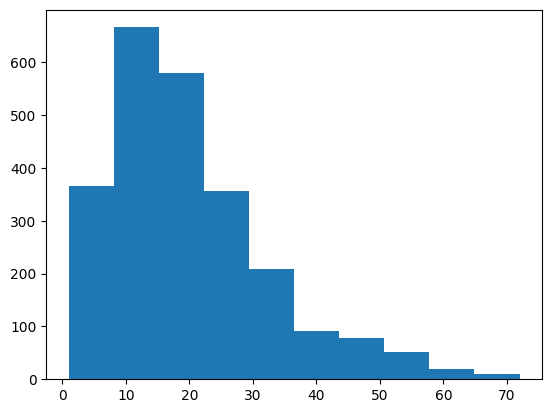

In [10]:
#data analysis

sequence_lengths = []

for i in range(len(X_train)):
  sequence_lengths.append(len(X_train[i]))

import matplotlib.pyplot as plt

plt.hist(sequence_lengths)
pd.Series(sequence_lengths).describe()

In [11]:
#max=72
#you look for the max tokens count to make numoy array
#we need sequence length to be the same
#make all the maximum
#zero padding
from copy import deepcopy

def pad_X(X, desired_sequence_length=73):#set to max
  X_copy = deepcopy(X)

  for i, x in enumerate(X):
    x_seq_len = x.shape[0]
    sequence_length_difference = desired_sequence_length - x_seq_len
#ading the pads # 50 is the glove
    pad = np.zeros(shape=(sequence_length_difference, 50)) #50 cause glove

    X_copy[i] = np.concatenate([x, pad]) #pad zeros at end

  return np.array(X_copy).astype(float)

In [12]:
X_train = pad_X(X_train)
X_train.shape, y_train.shape

((2427, 73, 50), (2427,))

In [13]:
X_val, y_val = df_to_X_y(val_df)
X_val = pad_X(X_val)
X_val.shape, y_val.shape

((520, 73, 50), (520,))

In [14]:
X_test, y_test = df_to_X_y(test_df)
X_test = pad_X(X_test)
X_test.shape, y_test.shape

((521, 73, 50), (521,))

In [15]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow as tf

In [16]:
model = tf.keras.Sequential([
            # Complex model with dropout
            tf.keras.layers.Input(shape=(73, 50)),
            #tf.keras.layers.Embedding(len(tokenizer.vocab), 32),
            tf.keras.layers.Dropout(0.3),  # Add dropout after the embedding layer
            tf.keras.layers.LSTM(32),
            tf.keras.layers.Dropout(0.3),  # Add dropout after the LSTM layer
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dropout(0.3),  # Add dropout after the Dense layer
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 73, 50)            0         
                                                                 
 lstm (LSTM)                 (None, 32)                10624     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 11169 (43.63 KB)
Trainable params: 11169 (

In [18]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import ModelCheckpoint

cp = ModelCheckpoint('model/', save_best_only=True)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=BinaryCrossentropy(),
              metrics=['accuracy', AUC(name='auc')])

In [19]:
frequencies = pd.value_counts(train_df['sarcastic'])

frequencies

0    1823
1     604
Name: sarcastic, dtype: int64

In [20]:
weights = {0: frequencies.sum() / frequencies[0], 1: frequencies.sum() / frequencies[1]}
weights

{0: 1.331321996708722, 1: 4.018211920529802}

In [21]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, callbacks=[cp], class_weight=weights)

Epoch 1/20
76/76 [==============================] - 10s 94ms/step - loss: 1.3860 - accuracy: 0.7149 - auc: 0.4982 - val_loss: 0.6903 - val_accuracy: 0.7385 - val_auc: 0.5121
Epoch 2/20
76/76 [==============================] - 7s 98ms/step - loss: 1.3851 - accuracy: 0.7285 - auc: 0.5119 - val_loss: 0.6897 - val_accuracy: 0.7385 - val_auc: 0.5164
Epoch 3/20
76/76 [==============================] - 7s 90ms/step - loss: 1.3849 - accuracy: 0.7293 - auc: 0.4975 - val_loss: 0.6891 - val_accuracy: 0.7385 - val_auc: 0.5116
Epoch 4/20
76/76 [==============================] - 4s 51ms/step - loss: 1.3855 - accuracy: 0.6980 - auc: 0.5052 - val_loss: 0.6894 - val_accuracy: 0.7385 - val_auc: 0.5144
Epoch 5/20
76/76 [==============================] - 6s 81ms/step - loss: 1.3852 - accuracy: 0.6613 - auc: 0.5084 - val_loss: 0.6890 - val_accuracy: 0.7385 - val_auc: 0.5141
Epoch 6/20
76/76 [==============================] - 7s 99ms/step - loss: 1.3852 - accuracy: 0.7103 - auc: 0.5066 - val_loss: 0.6885 - 

In [22]:
from tensorflow.keras.models import load_model

best_model = load_model('model/')

In [23]:
test_predictions = (best_model.predict(X_test) > 0.5).astype(int)

from sklearn.metrics import classification_report

print(classification_report(y_test, test_predictions))

17/17 [==============================] - 1s 11ms/step
              precision    recall  f1-score   support

           0       0.84      0.28      0.42       394
           1       0.27      0.83      0.41       127

    accuracy                           0.41       521
   macro avg       0.56      0.56      0.41       521
weighted avg       0.70      0.41      0.42       521

